In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from torch.utils.data import DataLoader

In [3]:
from transformers import BartTokenizer, BertTokenizer, BertForSequenceClassification, BartForConditionalGeneration,DataCollatorForSeq2Seq
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset, load_dataset
import torch

Some Custom Functionality

In [4]:
def split_utterances(convo_string):
    #patt = re.compile(r'([A-Za-z]+): (.{0,})$')
    errs = {}
    patt = re.compile(r'^(.{1,}): (.{0,})$')
    dialogue = convo_string.split('\n')
    utterances = {}
    i = 0
    for d in dialogue:
        try:
            grps = patt.match(d).groups()
            speaker = grps[0]
            utterance = grps[1]
            utterances[i] = (speaker,utterance)
            i+=1
        except:
            errs[i] = d
            i+=1
    return utterances,errs
    

    

In [5]:
def analyze_conversation(utterances):
    metrics = {}
    metrics['utterances'] = len(utterances)
    utterers = set(utterance[0] for utterance in utterances.values())
    chars = sum(len(utterance[1]) for utterance in utterances.values())
    metrics['utterers'] = len(utterers)
    share_u = dict.fromkeys(utterers,0)
    share_w = dict.fromkeys(utterers,0)
    for utter in utterances.values():
        share_u[utter[0]]+=1
        share_w[utter[0]]+=len(utter[1])
    
    metrics['utterance_share'] = sum((val/metrics['utterances'])**2 for _,val in share_u.items())
    metrics['word_share'] = sum((val/chars)**2 for _,val in share_w.items())

    return metrics

Load Datasets

In [6]:
df = load_dataset("knkarthick/samsum")

In [7]:
df_train = pd.DataFrame(columns=['id','dialogue','summary'])
df_train['id'] = df['train']['id']
df_train['dialogue'] = df['train']['dialogue']
df_train['summary'] = df['train']['summary']
print(df_train.shape)

(14732, 3)


In [8]:
print(f'There are now {df_train.duplicated().sum()} duplicates in the dataset.')
df_train.isna().sum()

There are now 0 duplicates in the dataset.


id          0
dialogue    1
summary     0
dtype: int64

We have a missing dialogue, oddly enough.  Let's handle:

In [9]:
df_train = df_train.dropna()
df_train.shape

(14731, 3)

Double check to make sure:

In [10]:
print(f'There are now {df_train.duplicated().sum()} duplicates in the dataset.')
print('Missing Values:')
df_train.isna().sum()

There are now 0 duplicates in the dataset.
Missing Values:


id          0
dialogue    0
summary     0
dtype: int64

In [11]:
df_valid = pd.DataFrame(columns=['id','dialogue','summary'])
df_valid['id'] = df['validation']['id']
df_valid['dialogue'] = df['validation']['dialogue']
df_valid['summary'] = df['validation']['summary']
print(df_valid.shape)

(818, 3)


In [12]:
print(f'There are now {df_valid.duplicated().sum()} duplicates in the dataset.')
print('Missing Values:')
df_valid.isna().sum()

There are now 0 duplicates in the dataset.
Missing Values:


id          0
dialogue    0
summary     0
dtype: int64

In [13]:
df_test = pd.DataFrame(columns=['id','dialogue','summary'])
df_test['id'] = df['test']['id']
df_test['dialogue'] = df['test']['dialogue']
df_test['summary'] = df['test']['summary']
print(df_test.shape)

(819, 3)


In [14]:
print(f'There are now {df_test.duplicated().sum()} duplicates in the dataset.')
print('Missing Values:')
df_test.isna().sum()

There are now 0 duplicates in the dataset.
Missing Values:


id          0
dialogue    0
summary     0
dtype: int64

In [15]:
df_all = pd.concat([df_train,df_test,df_valid])
df_all.shape

(16368, 3)

In [16]:
print(f'There are now {df_all.duplicated().sum()} duplicates in the dataset.')
print('Missing Values:')
df_all.isna().sum()

There are now 0 duplicates in the dataset.
Missing Values:


id          0
dialogue    0
summary     0
dtype: int64

Calculate Some Summary Metrics

In [17]:
conversations = pd.DataFrame(columns=['Original','Utterances'])
conversations['Original'] = df_all['dialogue']

In [18]:
samples = {}
errs = {}
count = 0
for d in df_all['dialogue']:
    if d is not None:
        results = split_utterances(d)
        samples[count] = results[0]
        if(len(results[1])>0): 
           errs[count] = results[1]
        count+=1


In [19]:
results = {}
errs_2 = {}

for count,sample in samples.items():
    results[count] = analyze_conversation(sample)


In [20]:
stats = pd.DataFrame(results).T
stats

,utterances,utterers,utterance_share,word_share
0,3.0,2.0,0.555556,0.861885
1,4.0,2.0,0.500000,0.558641
2,10.0,2.0,0.500000,0.524584
3,4.0,2.0,0.500000,0.500329
4,22.0,2.0,0.504132,0.505745
...,...,...,...,...
16363,22.0,2.0,0.500000,0.506895
16364,17.0,2.0,0.501730,0.502780
16365,28.0,2.0,0.510204,0.506543
16366,8.0,2.0,0.500000,0.501455


In [21]:
stats.describe()

,utterances,utterers,utterance_share,word_share
count,16368.000000,16368.000000,16368.000000,16368.000000
mean,11.148094,2.422654,0.467514,0.501281
std,6.441995,0.856406,0.084827,0.101933
min,2.000000,2.000000,0.081633,0.092088
25%,6.000000,2.000000,0.428571,0.488802
50%,10.000000,2.000000,0.500000,0.507775
75%,15.000000,3.000000,0.510204,0.541079
max,46.000000,14.000000,0.755102,0.984253


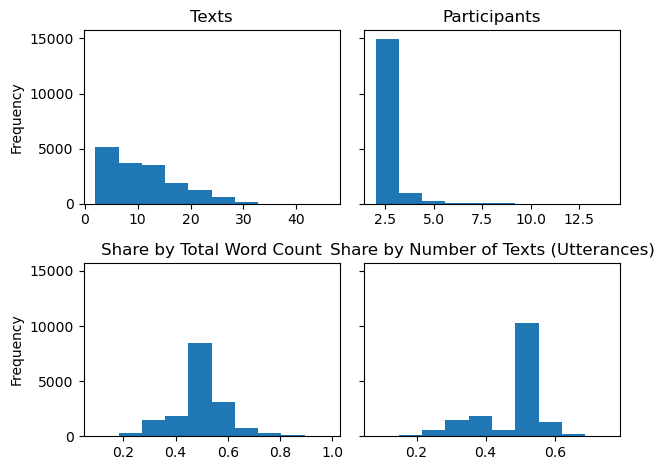

In [22]:
fig,axs = plt.subplots(nrows=2,ncols=2,sharey=True)
stats.utterances.plot.hist(ax=axs[0][0]);
axs[0][0].set_title('Texts')
stats.utterers.plot.hist(ax=axs[0][1]);
axs[0][1].set_title('Participants')
stats.utterance_share.plot.hist(ax=axs[1][1]);
axs[1][1].set_title('Share by Number of Texts (Utterances)')
stats.word_share.plot.hist(ax=axs[1][0]);
axs[1][0].set_title('Share by Total Word Count')
fig.tight_layout()


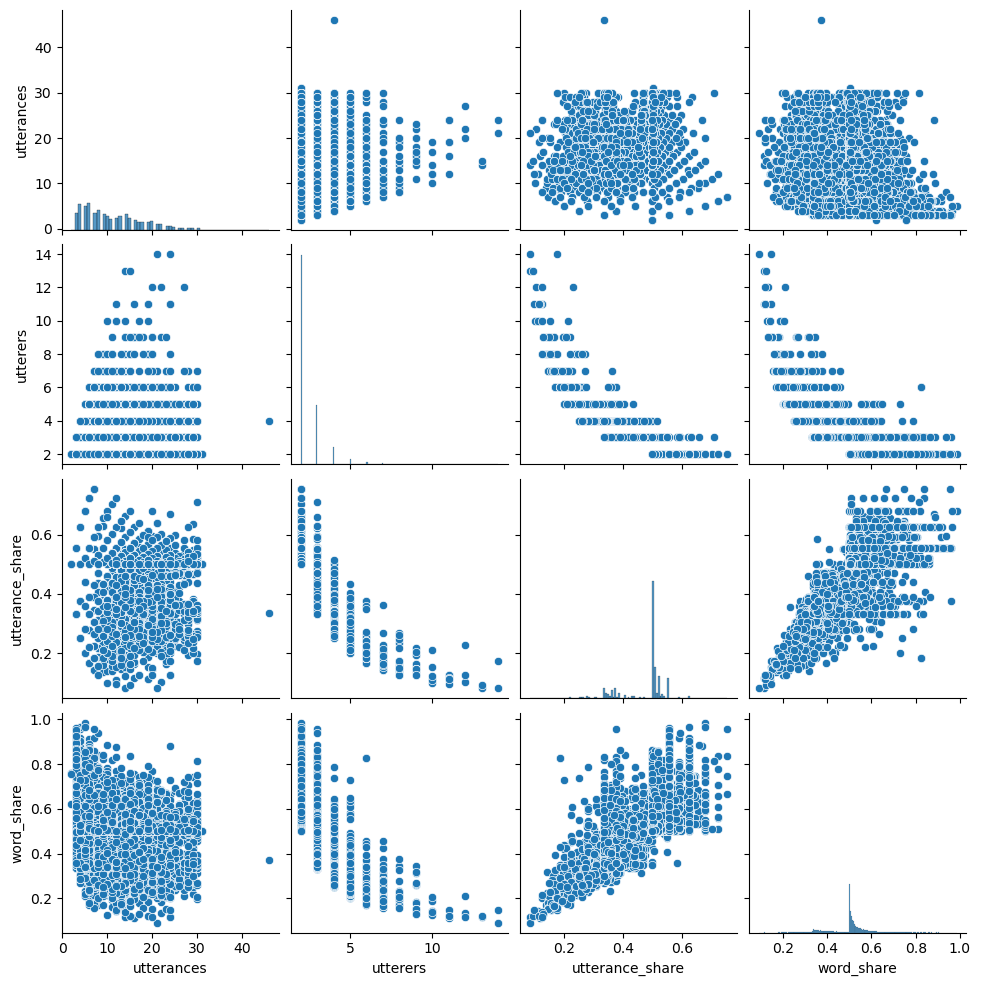

In [23]:
sns.pairplot(data=stats);

In [24]:
summ_length = pd.DataFrame([len(s) for s in df_all['summary']],columns=['Length'])
summ_length


,Length
0,56
1,61
2,77
3,97
4,145
...,...
16363,72
16364,282
16365,81
16366,127


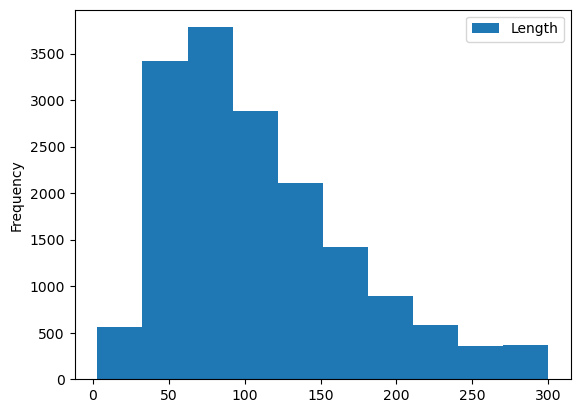

In [25]:
summ_length.plot.hist();

Emojis?

In [26]:
patt = re.compile(r'[:;][-~]?[)D]')
smiles = [bool(patt.search(d)) for d in df_train['dialogue'] if d is not None]
sum(smiles)

4702

In [27]:
patt = re.compile(r'[:;][-~]?[(]')
frowns = [bool(patt.search(d)) for d in df_train['dialogue'] if d is not None]
sum(frowns)

1029

Collect Subsample

In [28]:
keep_rate = {'train':.75,'test':.8,'valid':0.75}

In [29]:
df_train = df_train.sample(frac=keep_rate['train'])
df_test = df_test.sample(frac=keep_rate['test'])
df_valid = df_valid.sample(frac=keep_rate['valid'])

Build A Tokenizer

In [30]:
name = 'facebook/bart-base'
tokenizer = BartTokenizer.from_pretrained(name)


Use Tokenizer To Create Embeddings

In [31]:
max_len = 150

In [32]:
df_train['input_ids'] = [tokenizer.encode_plus(d,max_length=max_len,truncation=True)['input_ids'] for d in df_train['dialogue']]
df_train['attention_mask'] = [tokenizer.encode_plus(d,max_length=max_len,truncation=True)['attention_mask'] for d in df_train['dialogue']]
df_train['labels'] = [tokenizer.encode_plus(d,max_length=max_len,truncation=True)['input_ids'] for d in df_train['summary']]
ds_train = Dataset.from_pandas(df_train)

In [33]:
ds_train

Dataset({
    features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels', '__index_level_0__'],
    num_rows: 11048
})

In [34]:
df_valid['input_ids'] = [tokenizer.encode_plus(d,max_length=max_len,truncation=True)['input_ids'] for d in df_valid['dialogue']]
df_valid['attention_mask'] = [tokenizer.encode_plus(d,max_length=max_len,truncation=True)['attention_mask'] for d in df_valid['dialogue']]
df_valid['labels'] = [tokenizer.encode_plus(d,max_length=max_len,truncation=True)['input_ids'] for d in df_valid['summary']]
ds_valid = Dataset.from_pandas(df_valid)

In [35]:
ds_valid

Dataset({
    features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels', '__index_level_0__'],
    num_rows: 614
})

In [36]:
df_test['input_ids'] = [tokenizer.encode_plus(d,max_length=max_len,truncation=True)['input_ids'] for d in df_test['dialogue']]
df_test['attention_mask'] = [tokenizer.encode_plus(d,max_length=max_len,truncation=True)['attention_mask'] for d in df_test['dialogue']]
df_test['labels'] = [tokenizer.encode_plus(d,max_length=max_len,truncation=True)['input_ids'] for d in df_test['summary']]
ds_test = Dataset.from_pandas(df_test)

In [37]:
ds_test

Dataset({
    features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels', '__index_level_0__'],
    num_rows: 655
})

Build Generative Model

In [38]:
name = 'facebook/bart-base'
model = BartForConditionalGeneration.from_pretrained(name)

In [39]:
model.eval()

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

In [40]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [41]:
training_args = TrainingArguments(
    output_dir='.Deliverables/results',          # Directory
    num_train_epochs=2,              # Number of epochs for training
    learning_rate=2e-5,
    per_device_train_batch_size=5,   # Batch size per device during training
    per_device_eval_batch_size=5,    # Batch size for evaluation
    warmup_steps=500 ,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Weight decay for regularization
    logging_dir='./logs',            # Directory to save logs
    logging_steps=10,                # Log metrics every specified number of steps
    eval_strategy="epoch",             # Evaluation is done at the end of each epoch
    report_to='none',                 # Disables reporting
    #Need to adjust with these settings in order to get code to run
    dataloader_pin_memory=False,
    use_cpu=True
)

In [ ]:
# Initializing the Trainer object
trainer = Trainer(
    model=model,             # Original Model
    args=training_args,      # Training arguments specifying training parameters like learning rate, batch size, etc.
    data_collator=data_collator,    
    train_dataset=ds_train,  
    eval_dataset=ds_valid    
)

In [43]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.919200,1.737422
2,1.492700,1.698681


/opt/anaconda3/lib/python3.12/site-packages/transformers/modeling_utils.py:3464: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=4420, training_loss=1.9586452790514917, metrics={'train_runtime': 4975.244, 'train_samples_per_second': 4.441, 'train_steps_per_second': 0.888, 'total_flos': 1944821123481600.0, 'train_loss': 1.9586452790514917, 'epoch': 2.0})

In [44]:
weights = model.state_dict()
torch.save(weights,'Model_3.pth')
weights

OrderedDict([('final_logits_bias', tensor([[0., 0., 0.,  ..., 0., 0., 0.]])),
             ('model.shared.weight',
              tensor([[ 0.0133,  0.0014, -0.0100,  ...,  0.0032,  0.1063,  0.0098],
                      [-0.0130, -0.0162, -0.0178,  ..., -0.0130, -0.0046, -0.0048],
                      [ 0.0850, -0.0390,  0.0089,  ...,  0.0586,  0.0086,  0.0351],
                      ...,
                      [ 0.0124, -0.0234, -0.0202,  ..., -0.0045,  0.0237, -0.0065],
                      [ 0.0057, -0.0384, -0.0268,  ...,  0.0055,  0.0128, -0.0037],
                      [-0.0084,  0.0112, -0.0183,  ...,  0.0089, -0.0125,  0.0230]])),
             ('model.encoder.embed_tokens.weight',
              tensor([[ 0.0133,  0.0014, -0.0100,  ...,  0.0032,  0.1063,  0.0098],
                      [-0.0130, -0.0162, -0.0178,  ..., -0.0130, -0.0046, -0.0048],
                      [ 0.0850, -0.0390,  0.0089,  ...,  0.0586,  0.0086,  0.0351],
                      ...,
                     

In [45]:
def summarize_convo(dialogue,model,tokenizer):
    inputs = tokenizer.encode(dialogue,return_tensors='pt')
    summary_ids = model.generate(inputs, max_length=2000, num_beams=30, early_stopping=False)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [46]:
observation = df_test.iloc[28]
observation

id                                                         13730077
dialogue          James: I am driving there, need a ride?\nRicha...
summary                         James will pick up Richard at 6:15.
input_ids         [0, 18031, 35, 38, 524, 1428, 89, 6, 240, 10, ...
attention_mask    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
labels            [0, 18031, 40, 1339, 62, 2431, 23, 231, 35, 99...
Name: 579, dtype: object

In [47]:
summarize_convo(observation['dialogue'],model,tokenizer)

'Richard will be waiting for James at 6:15.'

In [ ]:
observation['dialogue']

In [ ]:
observation['summary']